<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave_agglomerative_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, silhouette_samples,adjusted_rand_score, homogeneity_score, completeness_score, davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import KernelPCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
train = pd.read_csv('drive/Shareddrives/Milestone 2/Training_set.csv', 
                      sep='\t',index_col='ix')
train['lemmatized_text'] = train['lemmatized_text'].fillna('')
train['lemmatized_text'] = train['lemmatized_text'].astype(str)
sample_df = train.groupby('label').apply(lambda x: x.sample(10000, random_state=99))
sample_df.index = sample_df.index.get_level_values(1)

In [5]:
#!pip install scattertext
!python -m spacy download en_core_web_lg

2022-10-18 01:40:37.348932: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 7.6 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [6]:
import spacy
nlp = spacy.load("en_core_web_lg")




In [12]:
sample_df['embedding'] =  (sample_df['lemmatized_text']
                           .apply(lambda doc: nlp(doc).vector))

X = pd.DataFrame([x for x in sample_df['embedding']])

In [8]:
preprocessor = Pipeline([('scaler', StandardScaler())])
X_std = preprocessor.fit_transform(X)

In [9]:
# n=20000
# some code obtained from https://www.projectpro.io/recipes/do-agglomerative-clustering-in-python


def find_best_agg_clusters(X,num_clust):
 
  X_pca = PCA(n_components=2).fit_transform(X)
  
  best_model = None
  m = {'cluster':[],
       'score':[],
       'homogenity': [],
       'completeness': [],
        'davies_bouldin':[]}
  fig, ax = plt.subplots(3,3, figsize=(15,15))
  fig.suptitle('Agglomerative Clustering')
  ax = ax.flatten()
  for idx, k in enumerate(num_clust):
    clt = AgglomerativeClustering(linkage="ward",
                                    affinity='euclidean',
                                    n_clusters=k
                                  )
    model = clt.fit(X_std)
    clusters = model.fit_predict(X_std)
    score = silhouette_score(X_std,clusters,
                    random_state=99)
    
    hg = homogeneity_score(sample_df.label, clusters)
    comp = completeness_score(sample_df.label, clusters)
    davies = davies_bouldin_score(X_std, clusters )


    scatter = ax[idx].scatter(X_pca[:,0],X_pca[:,1], 
                              c=clusters,s=50, cmap='viridis')
    ax[idx].set_title(f"k={k}")
    ax[idx].set_xlabel("X0"); 
    ax[idx].set_ylabel("X1")

    fig.colorbar(scatter, ax=ax[idx])

    m['cluster'].append(k)
    m['homogenity'].append(hg)
    m['completeness'].append(comp)
    m['davies_bouldin'].append(davies)

    if best_model == None:
      best_model = model
    elif score > np.max(m['score']):
      best_model = model    
    m['score'].append(score)
    

  return m, best_model





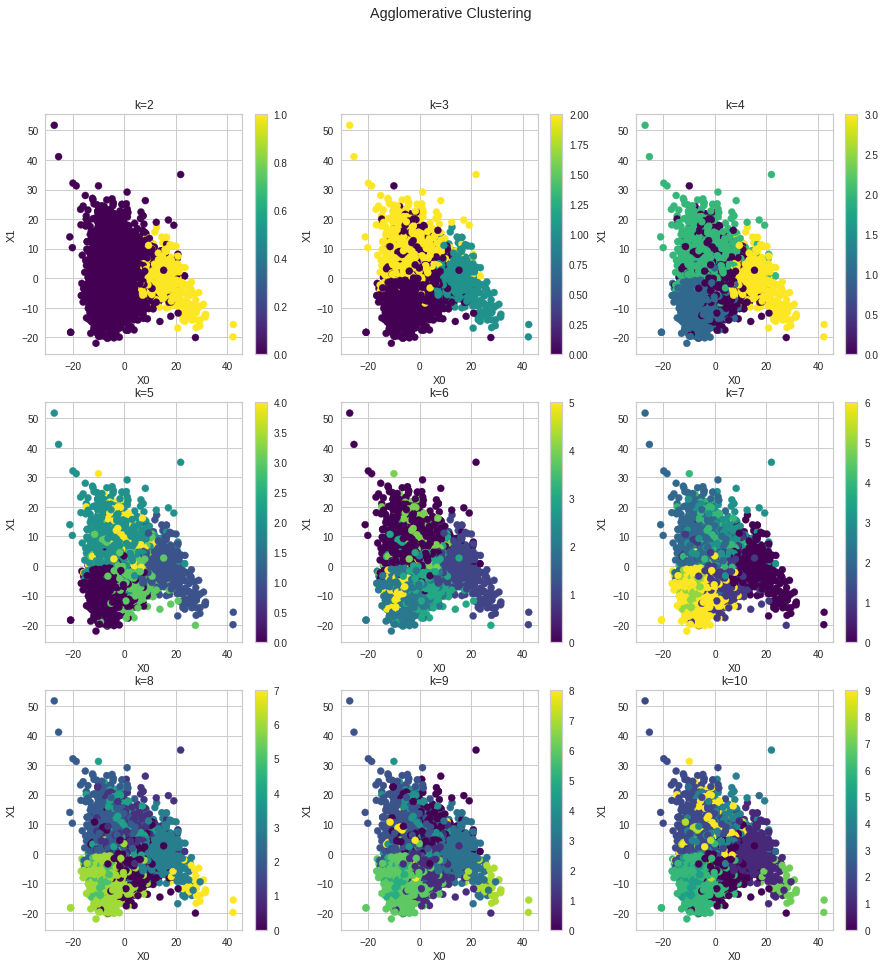

In [16]:
agg_results, best_agg_model = find_best_agg_clusters(X_std,[i for i in range(2,11)])


In [24]:
first_df = pd.DataFrame(agg_results)
first_df

,cluster,score,homogenity,completeness,davies_bouldin
0,2,0.150419,0.001539,0.002994,2.223902
1,3,0.074728,0.006199,0.004816,3.291161
2,4,0.030190,0.006460,0.003407,3.566415
3,5,0.028217,0.007003,0.003287,3.390317
4,6,0.005591,0.007275,0.003125,3.236478
5,7,0.010474,0.007471,0.002888,3.330240
6,8,0.012519,0.007894,0.003035,3.035196
7,9,0.014059,0.007900,0.002867,3.010803
8,10,0.016781,0.014624,0.005199,3.009828


In [18]:
best_agg_model.n_clusters_

2

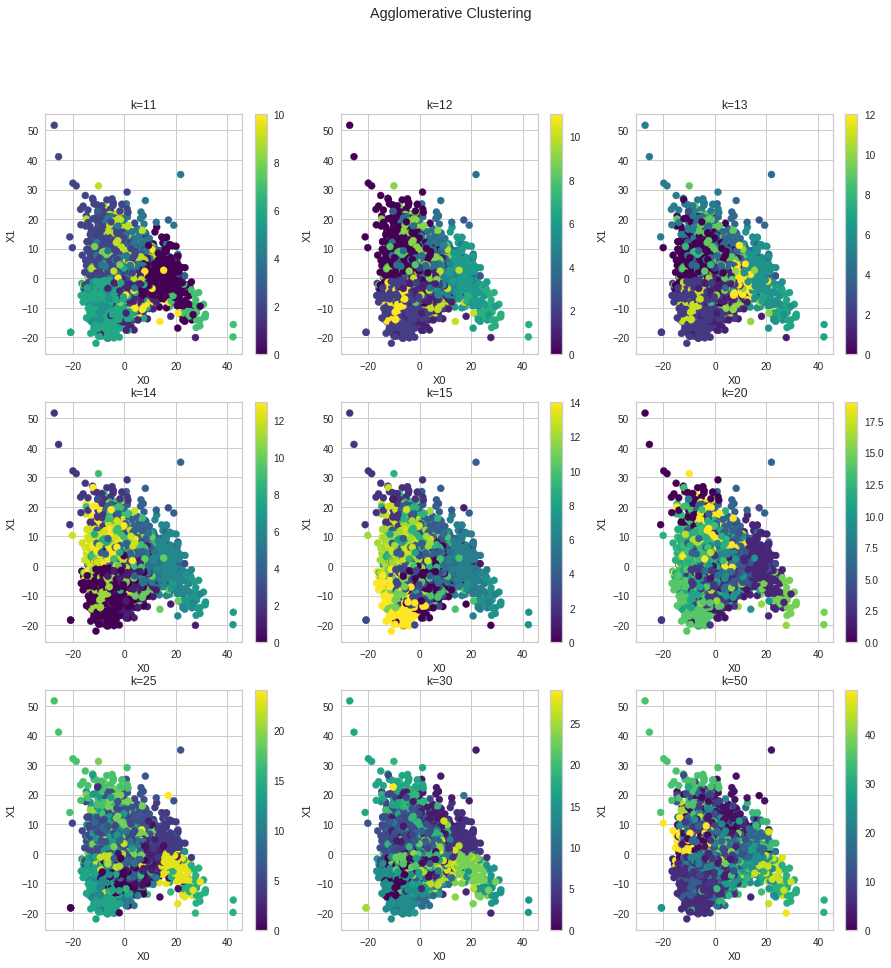

In [19]:
second_agg_results, best_rerun_agg_model = find_best_agg_clusters(X_std,[11,12,13,14,15,20,25,30,50])

In [26]:
second_df = pd.DataFrame(second_agg_results)
second_df

,cluster,score,homogenity,completeness,davies_bouldin
0,11,0.018517,0.014624,0.004851,3.124239
1,12,0.007089,0.016402,0.005246,3.171257
2,13,0.009057,0.018851,0.005916,3.140865
3,14,0.009862,0.019086,0.005762,3.123331
4,15,0.004423,0.020128,0.005848,3.196617
5,20,0.012835,0.020566,0.005285,3.204025
6,25,0.006330,0.022579,0.005393,3.079138
7,30,0.000938,0.023447,0.005255,3.039546
8,50,0.006571,0.035449,0.006984,2.780734


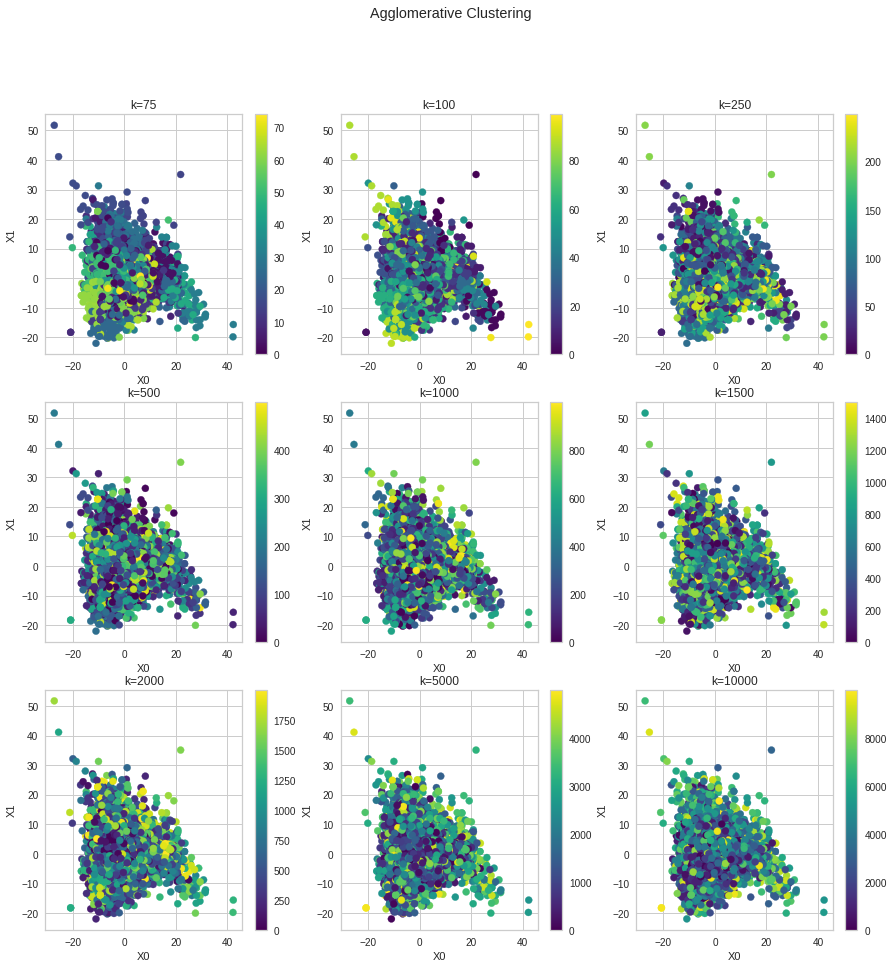

In [21]:
third_agg_results, best_thirdrun_agg_model = find_best_agg_clusters(X_std,[75,100,250,500,1000,1500,2000,5000,10000])

In [28]:
third_df = pd.DataFrame(third_agg_results).sort_values('score', ascending=False)
third_df


,cluster,score,homogenity,completeness,davies_bouldin
8,10000,0.182044,0.515601,0.040122,0.832651
7,5000,0.135898,0.285787,0.024360,1.279444
6,2000,0.075992,0.167289,0.016197,1.734868
5,1500,0.062053,0.145049,0.014648,1.854833
4,1000,0.044986,0.122970,0.013241,2.009741
3,500,0.028844,0.093909,0.011346,2.232461
2,250,0.011339,0.076544,0.010415,2.433159
1,100,0.005902,0.055478,0.009211,2.575826
0,75,-0.002164,0.040105,0.007019,2.720648


In [29]:
final_df = pd.concat([first_df, second_df, third_df])

In [30]:
final_df.to_csv('drive/Shareddrives/Milestone 2/Clustering/metrics/agglomerative.csv',sep='\t')

In [ ]:
fourth_agg_results, best_fourthrun_agg_model = find_best_agg_clusters(X_std,[11000,12000,13000,14000,15000,16000,17000,18000, 19000])

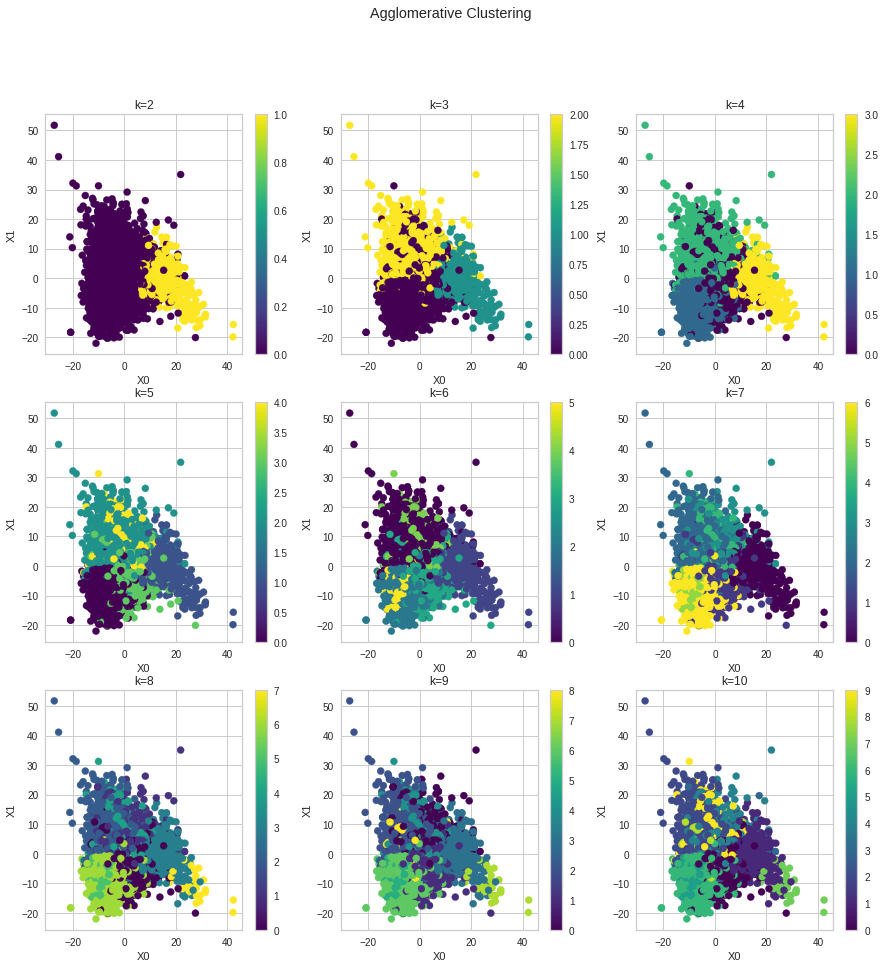

In [13]:
X_std = preprocessor.fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_std)
pca_results, pca_model = find_best_agg_clusters(X_pca,[x for x in range(2,11)])

In [14]:
pd.DataFrame(pca_results)

,cluster,score,homogenity,completeness,davies_bouldin
0,2,0.150419,0.001539,0.002994,2.223902
1,3,0.074728,0.006199,0.004816,3.291161
2,4,0.030190,0.006460,0.003407,3.566415
3,5,0.028217,0.007003,0.003287,3.390317
4,6,0.005591,0.007275,0.003125,3.236478
5,7,0.010474,0.007471,0.002888,3.330240
6,8,0.012519,0.007894,0.003035,3.035196
7,9,0.014059,0.007900,0.002867,3.010803
8,10,0.016781,0.014624,0.005199,3.009828


In [31]:
final_df.sort_values('score',ascending=False)

,cluster,score,homogenity,completeness,davies_bouldin
8,10000,0.182044,0.515601,0.040122,0.832651
0,2,0.150419,0.001539,0.002994,2.223902
7,5000,0.135898,0.285787,0.024360,1.279444
6,2000,0.075992,0.167289,0.016197,1.734868
1,3,0.074728,0.006199,0.004816,3.291161
5,1500,0.062053,0.145049,0.014648,1.854833
4,1000,0.044986,0.122970,0.013241,2.009741
2,4,0.030190,0.006460,0.003407,3.566415
3,500,0.028844,0.093909,0.011346,2.232461
3,5,0.028217,0.007003,0.003287,3.390317


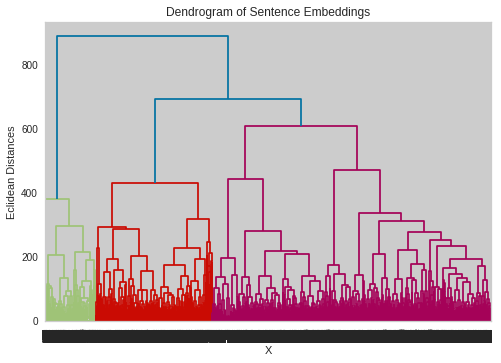

<Figure size 2880x1440 with 0 Axes>

In [35]:
import scipy.cluster.hierarchy as sch
cls = sch.ward(X_std)
dendrogram = sch.dendrogram(cls)
plt.title("Dendrogram of Sentence Embeddings")
plt.xlabel("X")
plt.ylabel("Eclidean Distances")
plt.figure(figsize=(40,20))
plt.tight_layout()
plt.savefig('drive/Shareddrives/Milestone 2/Clustering/dendogram.png',dpi=900)

dict

In [32]:
best_agg_model.children_

array([[15310, 15382],
       [ 9903, 19903],
       [10069, 16988],
       ...,
       [39994, 39995],
       [39993, 39996],
       [39992, 39997]])